In [7]:
import sys
print(sys.version)

import sklearn.ensemble
import shap
import numpy as np
import pandas as pd
import numba
import time
import json
import xgboost
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
import shap.benchmark

from shap import TreeExplainer as TreeCext

from shap.explainers.pytree import *

import lightgbm as lgb


3.10.6 (main, Nov 14 2022, 16:10:14) [GCC 11.3.0]


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
def run_explain(name, data, explainer, vals=False):
    measure_time = time.perf_counter
    start = measure_time()
    values = explainer(data)
    end = measure_time()
    print("name: {}, time: {}".format(name, end - start))
    return [name, values if vals else [], end - start]

def run_diff_explainers(model, data):

#     # use an independent masker
#     masker = shap.maskers.Independent(X_train)
#     pmasker = shap.maskers.Partition(X_train)
    explainers = [
        ("Tree", shap.explainers.Tree(model)),
        ("TreeBanz", shap.explainers.Tree(model,  use_banz=True)),
        ("NEW TreeBanz", shap.explainers.Tree(model,  use_banz=True, change_deltas=True)),
    #     ("Tree approx.", shap.explainers.Tree(model, masker, approximate=True)),
    #     ("Exact", shap.explainers.Exact(model.predict, masker)),
    ]

    return [run_explain(name, data, exp) for name, exp in explainers]

In [5]:
def run_explain2(name, data, explainer):
    measure_time = time.perf_counter
    start = measure_time()
    values = explainer(data)
    end = measure_time()
    print("name: {}, time: {}".format(name, end - start))
    return [name, values, end - start]

def run_diff_explainers2(model, data):

#     # use an independent masker
#     masker = shap.maskers.Independent(X_train)
#     pmasker = shap.maskers.Partition(X_train)
    explainers = [
        ("Tree", shap.explainers.Tree(model)),
        ("TreeBanz", shap.explainers.Tree(model,  use_banz=True)),
        ("NEW TreeBanz", shap.explainers.Tree(model,  use_banz=True, change_deltas=True)),
    #     ("Tree approx.", shap.explainers.Tree(model, masker, approximate=True)),
    #     ("Exact", shap.explainers.Exact(model.predict, masker)),
    ]

    return [run_explain2(name, data, exp) for name, exp in explainers]

In [3]:
np.set_printoptions(threshold=sys.maxsize)
# X,y = shap.datasets.communitiesandcrime()
X,y = shap.datasets.boston()
print(X.columns.values.tolist())
print(len(X.columns.values.tolist()))

print(X.shape)
print(y.shape)

['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']
13
(506, 13)
(506,)


In [6]:
# X,y = shap.datasets.boston()
# X = X.values
# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# model = sklearn.ensemble.RandomForestRegressor(n_estimators=1000, max_depth=13)
# model.fit(X_train, y_train)

# TreeBanzCext = shap.explainers.Tree(model, use_banz=True, change_deltas=True)
# TreeBanzCext(X_test)

1
# ex = TreeExplainer(model)
# res_banz_py = ex.banz_values(X_test)


1

In [7]:
# Zobaczmy na tym datasecie jaka glebokosc daje najlepsze wyszkolenie

# X,y = shap.datasets.boston()
# X = X.values
# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# scores = {}
# mean = 5

# for i in range(1,13):
#     pass
#     print(i)
#     scores[i] = 0
#     for j in range(mean):
#         model = sklearn.ensemble.RandomForestRegressor(n_estimators=1000, max_depth=i)
#         model.fit(X_train, y_train)
#         scores[i] = scores[i] + model.score(X_test, y_test)
#     scores[i] = scores[i] / mean

# scores

In [8]:
def item_generator(json_input, lookup_key):
    if isinstance(json_input, dict):
        for k, v in json_input.items():
            if k == lookup_key:
                yield v
            else:
                yield from item_generator(v, lookup_key)
    elif isinstance(json_input, list):
        for item in json_input:
            yield from item_generator(item, lookup_key)

def tree_depth(json_text):
    json_input = json.loads(json_text)
    return max(list(item_generator(json_input, 'depth'))) + 1


In [9]:
import shap.datasets as ds

def a(x):
    X, y = x
    print(X.shape)

a(ds.adult())
a(ds.boston())
a(ds.communitiesandcrime())
a(ds.corrgroups60())
a(ds.diabetes())
a(ds.imagenet50())
# a(ds.imdb())
a(ds.independentlinear60())
a(ds.iris())
a(ds.nhanesi())

(32561, 12)
(506, 13)
(1994, 101)
(1000, 60)
(442, 10)
(50, 224, 224, 3)
(1000, 60)
(150, 4)
(14264, 79)


In [10]:
# Zobaczmy na tym datasecie jaka glebokosc daje najlepsze wyszkolenie

X,y = shap.datasets.nhanesi()
X = X.values
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=7, test_size=0.2)

xgb_full = xgboost.DMatrix(X, label=y)
xgb_train = xgboost.DMatrix(X_train, label=y_train)
xgb_test = xgboost.DMatrix(X_test, label=y_test)

scores = {}
mean_depths = {}
stddev_depths = {}
full_depths = {}

mean = 10

for i in range(1,2,1):
# for i in range(1,32,1):
    print(i)
    scores[i] = 0
    mean_depths[i] = 0
    stddev_depths[i] = 0
    for j in range(mean):
        params = {
            "eta": 0.002,
            "max_depth": 3,
            "objective": "survival:cox",
            "subsample": 0.5
        }
#         model = xgboost.train(params, xgb_train, 10000, evals = [(xgb_test, "test")], verbose_eval=1000)
        model = xgboost.XGBRegressor(n_estimators=1000, max_depth=i, subsample=0.5)
#         X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
        model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False, early_stopping_rounds=10)
        scores[i] = scores[i] + model.score(X_test, y_test)
        
        booster = model.get_booster()
        tree_df = booster.trees_to_dataframe()
#         print("rysuje drzewo")
#         xgboost.plotting.plot_tree(booster)
#         print(booster.get_dump(dump_format = "json").head())
        depths = [tree_depth(x) for x in booster.get_dump(dump_format = "json")]
        full_depths[i] = depths
        mean_depths[i] = mean_depths[i] + np.mean(depths)
        stddev_depths[i] = stddev_depths[i] + np.std(depths)
        
    scores[i] = scores[i] / mean
    mean_depths[i] = mean_depths[i] / mean
    stddev_depths[i] = stddev_depths[i] / mean

print(scores)
# print(mean_depths)
# print(stddev_depths)


1
{1: 0.35595893770551873}


In [11]:
#przyklad lundberga:
X,y = shap.datasets.nhanesi()
X_display,y_display = shap.datasets.nhanesi(display=True) # human readable feature values

xgb_full = xgboost.DMatrix(X, label=y)

# create a train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)
xgb_train = xgboost.DMatrix(X_train, label=y_train)
xgb_test = xgboost.DMatrix(X_test, label=y_test)

# use validation set to choose # of trees
params = {
    "eta": 0.002,
    "max_depth": 3,
    "objective": "survival:cox",
    "subsample": 0.5
}
# model_train = xgboost.train(params, xgb_train, 10000, evals = [(xgb_test, "test")], verbose_eval=1000)

# train final model on the full data set
params = {
    "eta": 0.002,
    "max_depth": 3, 
    "objective": "survival:cox",
    "subsample": 0.5
}
model_full = xgboost.train(params, xgb_full, 5000, evals = [(xgb_full, "test")], verbose_eval=1000)

def c_statistic_harrell(pred, labels):
    total = 0
    matches = 0
    for i in range(len(labels)):
        for j in range(len(labels)):
            if labels[j] > 0 and abs(labels[i]) > labels[j]:
                total += 1
                if pred[j] > pred[i]:
                    matches += 1
    return matches/total

# see how well we can order people by survival
c_statistic_harrell(model_full.predict(xgb_test, ntree_limit=5000), y_test)

[0]	test-cox-nloglik:9.28408
[1000]	test-cox-nloglik:8.60854
[2000]	test-cox-nloglik:8.53116
[3000]	test-cox-nloglik:8.49403
[4000]	test-cox-nloglik:8.47058
[4999]	test-cox-nloglik:8.45255


0.8354598601693753

In [12]:
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import r2_score

res = model_full.predict(xgb_test)

print(np.sqrt(MSE(res, y_test)))
print(r2_score(res, y_test))

16.95208156660044
-92.30155036647064


In [13]:
covid = pd.read_csv('../../data/Covid Data.csv')

print(covid.shape)

cols = ['PNEUMONIA','DIABETES', 'COPD', 'ASTHMA', 'INMSUPR','HIPERTENSION', 
        'OTHER_DISEASE', 'CARDIOVASCULAR', 'OBESITY','RENAL_CHRONIC', 'TOBACCO']
for col in cols :
    covid = covid[(covid[col] == 1)|(covid[col] == 2)]
    
covid['DEATH'] = [2 if row=='9999-99-99' else 1 for row in covid['DATE_DIED']]

covid['DEATH'].value_counts()

covid.drop(columns=['INTUBED','ICU','DATE_DIED'],inplace=True)

covid['PREGNANT'] = covid['PREGNANT'].replace(97,2)
covid['PREGNANT'] = covid['PREGNANT'].replace(98,2)

y = covid['CLASIFFICATION_FINAL']
X = covid.drop('CLASIFFICATION_FINAL', axis=1)

y.head()

(1048575, 21)


0    3
1    5
2    3
3    7
4    3
Name: CLASIFFICATION_FINAL, dtype: int64

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()
print("training")
log_reg.fit(X_train, y_train)
print("testing")
print("Logistic Regression Accuracy :", log_reg.score(X_test, y_test))

training
testing
Logistic Regression Accuracy : 0.5364896040111008


In [15]:
i=13
model = sklearn.ensemble.RandomForestClassifier(max_depth=i)
model.fit(X_train, y_train)
print("{}: {}\n--------------------------------".format(i, model.score(X_test, y_test)))
model_default = sklearn.ensemble.RandomForestClassifier()
model_default.fit(X_train, y_train)
model_default.score(X_test, y_test)

13: 0.5464198096873156
--------------------------------


0.5261497041910735

In [16]:
X_test.shape

(205031, 18)

In [17]:
for i in range(25,26,20):
    X_2 = X_test[:i]
    print("{}: {}".format(i, X_2.shape))
    start = time.time()
    run_diff_explainers(model, X_2)
    run_diff_explainers(model_default, X_2)
    print(time.time()-start)
    print("------------------------")

25: (25, 18)
ile drzew cext? 100
ile drzew cext? 100
ile drzew cext? 100
running with BANZ=False
using treeshap and cext
here37
using dense_Tree_pred
name: Tree, time: 4.139129353003227
running with BANZ=True
using treeshap and cext
using BANZ
name: TreeBanz, time: 1.354392198001733
running with BANZ=True
using treeshap and cext
using BANZ
name: NEW TreeBanz, time: 1.3189490680015297
ile drzew cext? 100
ile drzew cext? 100
ile drzew cext? 100
running with BANZ=False
using treeshap and cext
here37
using dense_Tree_pred
name: Tree, time: 159.22741826499987
running with BANZ=True
using treeshap and cext
using BANZ
name: TreeBanz, time: 22.751373607999994
running with BANZ=True
using treeshap and cext
using BANZ
name: NEW TreeBanz, time: 21.405153003001033
219.28350472450256
------------------------


In [18]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)

# model = xgboost.XGBClassifier(max_depth=13)
model_xgb = xgboost.XGBClassifier()
start = time.time()
model_xgb.fit(X_train, y_train)
end = time.time() - start
print("time to train: {}".format(end))
model_xgb.score(X_test, y_test)

time to train: 193.23614311218262


0.5474489223580824

In [19]:
X_test.shape

(205031, 18)

In [20]:
run_diff_explainers(model_xgb, X_test)
13

ile drzew cext? 700
ile drzew cext? 700
ile drzew cext? 700
running with BANZ=False
name: Tree, time: 161.54650388800292
running with BANZ=True
name: TreeBanz, time: 139.84836968799937
running with BANZ=True
name: NEW TreeBanz, time: 159.61856063099913


13

In [21]:
from sklearn.datasets import load_wine
X, y = load_wine(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.3)

model = sklearn.ensemble.RandomForestClassifier()
start = time.time()
model.fit(X_train, y_train)
end = time.time() - start
print("time to train: {}".format(end))
model.score(X_test, y_test)

time to train: 0.07662582397460938


1.0

In [22]:
run_diff_explainers(model, X)
13

ile drzew cext? 100
ile drzew cext? 100
ile drzew cext? 100
running with BANZ=False
using treeshap and cext
here37
using dense_Tree_pred
name: Tree, time: 0.014697544997034129
running with BANZ=True
using treeshap and cext
using BANZ
name: TreeBanz, time: 0.019886000001861248
running with BANZ=True
using treeshap and cext
using BANZ
name: NEW TreeBanz, time: 0.018931869002699386


13

## FRAUD DATABASE

In [8]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler

df = pd.read_csv('../../data/Base.csv')
# remove "device_fraud_count"
df = df.drop(['device_fraud_count'], axis=1, errors='ignore') # It's 0 for all rows

df['fraud_bool'].value_counts()

X = df.drop(['fraud_bool'], axis=1)
y = df['fraud_bool']


# Train test split by 'month', month 0-5 are train, 6-7 are test data as proposed in the paper
X_train = X[X['month']<6]
X_test = X[X['month']>=6]
y_train = y[X['month']<6]
y_test = y[X['month']>=6]

X_train.drop('month', axis=1, inplace=True)
X_test.drop('month', axis=1, inplace=True)

# y_train = le.fit_transform(y_train)
# y_test = le.fit_transform(y_test)

# onehot encoding for categorical variables
s = (X_train.dtypes == 'object')
object_cols = list(s[s].index)

ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
ohe_cols_train = pd.DataFrame(ohe.fit_transform(X_train[object_cols]))
ohe_cols_test = pd.DataFrame(ohe.transform(X_test[object_cols]))

ohe_cols_train.index = X_train.index
ohe_cols_test.index = X_test.index

num_X_train = X_train.drop(object_cols, axis=1)
num_X_test = X_test.drop(object_cols, axis=1)

X_train = pd.concat([num_X_train, ohe_cols_train], axis=1)
X_test = pd.concat([num_X_test, ohe_cols_test], axis=1)

# Scale data
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)



In [30]:
model_ranfor = sklearn.ensemble.RandomForestClassifier()
start = time.process_time()
model_ranfor.fit(X_train, y_train)
end = time.process_time() - start
print("time to train: {}".format(end))
model_ranfor.score(X_test, y_test)

time to train: 195.41889309883118


0.9859714844569316

In [10]:
TreeShap = shap.explainers.Tree(model_ranfor)
TreeBanz = shap.explainers.Tree(model_ranfor, use_banz=True)

ile drzew cext? 100
ile drzew cext? 100


In [ ]:
accurs = {}
for i in range(1,20):
    for j in range(100, 2000, 200):
        print("depth={}, n_est={}".format(i, j))
        model = sklearn.ensemble.RandomForestClassifier(max_depth=i, n_estimators=j)
        start = time.process_time()
        model.fit(X_train, y_train)
        end = time.process_time() - start
        print("time to train: {}".format(end))
        score = model.score(X_test, y_test)
        print("score:{}".format(score))
        accurs[(i, j)] = score

# ts = TreeShap(X_test[0])
accurs

depth=1, n_est=100
time to train: 16.320430692000173
score:0.9859617288828404
depth=1, n_est=300
time to train: 46.59783549099984
score:0.9859617288828404
depth=1, n_est=500
time to train: 77.749164415
score:0.9859617288828404
depth=1, n_est=700
time to train: 109.2559695179998
score:0.9859617288828404
depth=1, n_est=900
time to train: 142.3578384870002
score:0.9859617288828404
depth=1, n_est=1100
time to train: 170.24236431500003
score:0.9859617288828404
depth=1, n_est=1300
time to train: 201.21230461199957
score:0.9859617288828404
depth=1, n_est=1500
time to train: 237.76735550599915
score:0.9859617288828404
depth=1, n_est=1700
time to train: 266.74735338700066
score:0.9859617288828404
depth=1, n_est=1900


In [28]:
# ts[0]

In [29]:
# TreeBanz(X_test[0])

In [32]:
print(X_test.shape)
run_diff_explainers(model_ranfor, X_test[:100])
13

(205011, 50)
ile drzew cext? 100
ile drzew cext? 100
ile drzew cext? 100
running with BANZ=False
using treeshap and cext
here37
using dense_Tree_pred
name: Tree, time: 102.87892459999966
running with BANZ=True
using treeshap and cext
using BANZ
name: TreeBanz, time: 18.98152260400002
running with BANZ=True
using treeshap and cext
using BANZ
name: NEW TreeBanz, time: 18.911746034000316


13

In [33]:
depths = [x.get_depth() for x in model_ranfor.estimators_]
print(np.mean(depths))
print(np.std(depths))

39.08
2.261327044016411


In [34]:
model = sklearn.ensemble.RandomForestClassifier(max_depth=13)
start = time.time()
model.fit(X_train, y_train)
end = time.time() - start
print("time to train: {}".format(end))
print("score:{}".format(model.score(X_test, y_test)))

time to train: 130.6226954460144
score:0.985966606669886


In [35]:
print(X_test.shape)
run_diff_explainers(model, X_test[:1000])

depths = [x.get_depth() for x in model.estimators_]
print(np.mean(depths))
print(np.std(depths))

(205011, 50)
ile drzew cext? 100
ile drzew cext? 100
ile drzew cext? 100
running with BANZ=False
using treeshap and cext
here37
using dense_Tree_pred
name: Tree, time: 73.04433978500037
running with BANZ=True
using treeshap and cext
using BANZ
name: TreeBanz, time: 29.116902256000685
running with BANZ=True
using treeshap and cext
using BANZ
name: NEW TreeBanz, time: 28.97886926299998
13.0
0.0


In [36]:
run_diff_explainers(model, X_test[:10])
13

ile drzew cext? 100
ile drzew cext? 100
ile drzew cext? 100
running with BANZ=False
using treeshap and cext
here37
using dense_Tree_pred
name: Tree, time: 0.7606005440002264
running with BANZ=True
using treeshap and cext
using BANZ
name: TreeBanz, time: 0.30262768200009305
running with BANZ=True
using treeshap and cext
using BANZ
name: NEW TreeBanz, time: 0.3306810789999872


13

In [19]:
# X_train.values

In [20]:
model = lgb.LGBMClassifier(learning_rate=0.09,max_depth=-5,random_state=42)
model.fit(X_train,y_train,eval_set=[(X_test,y_test),(X_train,y_train)],
          verbose=20,eval_metric='logloss')
print('Testing accuracy {:.4f}'.format(model.score(X_test,y_test)))

[20]	training's binary_logloss: 0.0442617	valid_0's binary_logloss: 0.0580862
[40]	training's binary_logloss: 0.0418452	valid_0's binary_logloss: 0.0561485
[60]	training's binary_logloss: 0.0403772	valid_0's binary_logloss: 0.0556362
[80]	training's binary_logloss: 0.0391924	valid_0's binary_logloss: 0.0555138
[100]	training's binary_logloss: 0.0381692	valid_0's binary_logloss: 0.0554788
Testing accuracy 0.9858


In [21]:
run_diff_explainers(model, X_test)

ile drzew cext? 100
ile drzew cext? 100
ile drzew cext? 100
running with BANZ=False
name: Tree, time: 36.54892278099999
running with BANZ=True
name: TreeBanz, time: 36.33925635799994
running with BANZ=True
name: NEW TreeBanz, time: 37.22288930800005


[['Tree', [], 36.54892278099999],
 ['TreeBanz', [], 36.33925635799994],
 ['NEW TreeBanz', [], 37.22288930800005]]

In [22]:
model_xgb = xgboost.XGBClassifier()
start = time.time()
model_xgb.fit(X_train, y_train)
end = time.time() - start
print("time to train: {}".format(end))
model_xgb.score(X_test, y_test)

time to train: 63.67227816581726


0.9857519840398807

In [23]:
run_diff_explainers(model_xgb, X_test)


ile drzew cext? 100
ile drzew cext? 100
ile drzew cext? 100
running with BANZ=False
name: Tree, time: 36.48176613600003
running with BANZ=True
name: TreeBanz, time: 35.63589179900009
running with BANZ=True
name: NEW TreeBanz, time: 30.255851040999914


[['Tree', [], 36.48176613600003],
 ['TreeBanz', [], 35.63589179900009],
 ['NEW TreeBanz', [], 30.255851040999914]]

In [24]:
import catboost
model_cat = catboost.CatBoostClassifier()
start = time.time()
model_cat.fit(X_train, y_train)
end = time.time() - start
print("time to train: {}".format(end))
model_cat.score(X_test, y_test)

Learning rate set to 0.178397
0:	learn: 0.3688708	total: 106ms	remaining: 1m 46s
1:	learn: 0.2148498	total: 177ms	remaining: 1m 28s
2:	learn: 0.1335962	total: 224ms	remaining: 1m 14s
3:	learn: 0.0981844	total: 275ms	remaining: 1m 8s
4:	learn: 0.0745458	total: 344ms	remaining: 1m 8s
5:	learn: 0.0624702	total: 392ms	remaining: 1m 4s
6:	learn: 0.0559513	total: 457ms	remaining: 1m 4s
7:	learn: 0.0521974	total: 531ms	remaining: 1m 5s
8:	learn: 0.0499171	total: 580ms	remaining: 1m 3s
9:	learn: 0.0485291	total: 669ms	remaining: 1m 6s
10:	learn: 0.0473686	total: 722ms	remaining: 1m 4s
11:	learn: 0.0465688	total: 776ms	remaining: 1m 3s
12:	learn: 0.0460627	total: 823ms	remaining: 1m 2s
13:	learn: 0.0455899	total: 867ms	remaining: 1m 1s
14:	learn: 0.0452433	total: 919ms	remaining: 1m
15:	learn: 0.0449628	total: 965ms	remaining: 59.4s
16:	learn: 0.0448016	total: 1.03s	remaining: 59.8s
17:	learn: 0.0445507	total: 1.08s	remaining: 59s
18:	learn: 0.0443940	total: 1.13s	remaining: 58.5s
19:	learn: 0.

164:	learn: 0.0399463	total: 9.45s	remaining: 47.8s
165:	learn: 0.0399298	total: 9.52s	remaining: 47.9s
166:	learn: 0.0399158	total: 9.57s	remaining: 47.7s
167:	learn: 0.0398991	total: 9.63s	remaining: 47.7s
168:	learn: 0.0398907	total: 9.68s	remaining: 47.6s
169:	learn: 0.0398785	total: 9.74s	remaining: 47.5s
170:	learn: 0.0398638	total: 9.78s	remaining: 47.4s
171:	learn: 0.0398526	total: 9.82s	remaining: 47.3s
172:	learn: 0.0398389	total: 9.88s	remaining: 47.2s
173:	learn: 0.0398288	total: 9.96s	remaining: 47.3s
174:	learn: 0.0398164	total: 10s	remaining: 47.3s
175:	learn: 0.0398122	total: 10.1s	remaining: 47.2s
176:	learn: 0.0397974	total: 10.1s	remaining: 47.1s
177:	learn: 0.0397850	total: 10.2s	remaining: 47s
178:	learn: 0.0397704	total: 10.2s	remaining: 46.9s
179:	learn: 0.0397587	total: 10.3s	remaining: 46.8s
180:	learn: 0.0397440	total: 10.3s	remaining: 46.7s
181:	learn: 0.0397356	total: 10.4s	remaining: 46.6s
182:	learn: 0.0397184	total: 10.4s	remaining: 46.5s
183:	learn: 0.03

325:	learn: 0.0380547	total: 18.5s	remaining: 38.3s
326:	learn: 0.0380423	total: 18.6s	remaining: 38.2s
327:	learn: 0.0380320	total: 18.6s	remaining: 38.1s
328:	learn: 0.0380258	total: 18.7s	remaining: 38.1s
329:	learn: 0.0380146	total: 18.7s	remaining: 38s
330:	learn: 0.0379961	total: 18.8s	remaining: 38s
331:	learn: 0.0379834	total: 18.9s	remaining: 37.9s
332:	learn: 0.0379805	total: 18.9s	remaining: 37.9s
333:	learn: 0.0379636	total: 19s	remaining: 37.8s
334:	learn: 0.0379496	total: 19s	remaining: 37.8s
335:	learn: 0.0379377	total: 19.1s	remaining: 37.7s
336:	learn: 0.0379264	total: 19.1s	remaining: 37.6s
337:	learn: 0.0379073	total: 19.2s	remaining: 37.5s
338:	learn: 0.0378976	total: 19.2s	remaining: 37.5s
339:	learn: 0.0378896	total: 19.3s	remaining: 37.4s
340:	learn: 0.0378823	total: 19.3s	remaining: 37.3s
341:	learn: 0.0378732	total: 19.4s	remaining: 37.3s
342:	learn: 0.0378641	total: 19.4s	remaining: 37.2s
343:	learn: 0.0378538	total: 19.5s	remaining: 37.2s
344:	learn: 0.037843

487:	learn: 0.0365073	total: 28.1s	remaining: 29.5s
488:	learn: 0.0364990	total: 28.2s	remaining: 29.4s
489:	learn: 0.0364871	total: 28.2s	remaining: 29.4s
490:	learn: 0.0364836	total: 28.3s	remaining: 29.3s
491:	learn: 0.0364789	total: 28.3s	remaining: 29.2s
492:	learn: 0.0364689	total: 28.4s	remaining: 29.2s
493:	learn: 0.0364598	total: 28.5s	remaining: 29.1s
494:	learn: 0.0364490	total: 28.5s	remaining: 29.1s
495:	learn: 0.0364416	total: 28.6s	remaining: 29s
496:	learn: 0.0364328	total: 28.6s	remaining: 29s
497:	learn: 0.0364246	total: 28.7s	remaining: 28.9s
498:	learn: 0.0364094	total: 28.7s	remaining: 28.8s
499:	learn: 0.0364049	total: 28.8s	remaining: 28.8s
500:	learn: 0.0364015	total: 28.8s	remaining: 28.7s
501:	learn: 0.0363943	total: 28.9s	remaining: 28.7s
502:	learn: 0.0363850	total: 29s	remaining: 28.7s
503:	learn: 0.0363803	total: 29.1s	remaining: 28.6s
504:	learn: 0.0363679	total: 29.1s	remaining: 28.6s
505:	learn: 0.0363572	total: 29.2s	remaining: 28.5s
506:	learn: 0.0363

647:	learn: 0.0351058	total: 37.2s	remaining: 20.2s
648:	learn: 0.0350983	total: 37.3s	remaining: 20.2s
649:	learn: 0.0350974	total: 37.3s	remaining: 20.1s
650:	learn: 0.0350915	total: 37.4s	remaining: 20s
651:	learn: 0.0350901	total: 37.4s	remaining: 20s
652:	learn: 0.0350853	total: 37.5s	remaining: 19.9s
653:	learn: 0.0350837	total: 37.6s	remaining: 19.9s
654:	learn: 0.0350783	total: 37.6s	remaining: 19.8s
655:	learn: 0.0350690	total: 37.7s	remaining: 19.8s
656:	learn: 0.0350607	total: 37.7s	remaining: 19.7s
657:	learn: 0.0350556	total: 37.8s	remaining: 19.6s
658:	learn: 0.0350470	total: 37.9s	remaining: 19.6s
659:	learn: 0.0350360	total: 37.9s	remaining: 19.5s
660:	learn: 0.0350234	total: 38s	remaining: 19.5s
661:	learn: 0.0350121	total: 38s	remaining: 19.4s
662:	learn: 0.0350026	total: 38.1s	remaining: 19.4s
663:	learn: 0.0349992	total: 38.2s	remaining: 19.3s
664:	learn: 0.0349959	total: 38.2s	remaining: 19.3s
665:	learn: 0.0349907	total: 38.3s	remaining: 19.2s
666:	learn: 0.034984

808:	learn: 0.0338058	total: 46.7s	remaining: 11s
809:	learn: 0.0337969	total: 46.7s	remaining: 11s
810:	learn: 0.0337931	total: 46.8s	remaining: 10.9s
811:	learn: 0.0337839	total: 46.8s	remaining: 10.8s
812:	learn: 0.0337768	total: 46.9s	remaining: 10.8s
813:	learn: 0.0337704	total: 47s	remaining: 10.7s
814:	learn: 0.0337676	total: 47s	remaining: 10.7s
815:	learn: 0.0337589	total: 47.1s	remaining: 10.6s
816:	learn: 0.0337492	total: 47.1s	remaining: 10.6s
817:	learn: 0.0337438	total: 47.2s	remaining: 10.5s
818:	learn: 0.0337377	total: 47.2s	remaining: 10.4s
819:	learn: 0.0337340	total: 47.3s	remaining: 10.4s
820:	learn: 0.0337270	total: 47.3s	remaining: 10.3s
821:	learn: 0.0337197	total: 47.4s	remaining: 10.3s
822:	learn: 0.0337126	total: 47.5s	remaining: 10.2s
823:	learn: 0.0337013	total: 47.5s	remaining: 10.1s
824:	learn: 0.0336885	total: 47.6s	remaining: 10.1s
825:	learn: 0.0336797	total: 47.6s	remaining: 10s
826:	learn: 0.0336708	total: 47.7s	remaining: 9.98s
827:	learn: 0.0336653	

970:	learn: 0.0326129	total: 56s	remaining: 1.67s
971:	learn: 0.0326056	total: 56.1s	remaining: 1.62s
972:	learn: 0.0325986	total: 56.1s	remaining: 1.56s
973:	learn: 0.0325946	total: 56.2s	remaining: 1.5s
974:	learn: 0.0325925	total: 56.3s	remaining: 1.44s
975:	learn: 0.0325820	total: 56.3s	remaining: 1.38s
976:	learn: 0.0325696	total: 56.4s	remaining: 1.33s
977:	learn: 0.0325642	total: 56.4s	remaining: 1.27s
978:	learn: 0.0325598	total: 56.5s	remaining: 1.21s
979:	learn: 0.0325580	total: 56.6s	remaining: 1.15s
980:	learn: 0.0325567	total: 56.6s	remaining: 1.1s
981:	learn: 0.0325495	total: 56.6s	remaining: 1.04s
982:	learn: 0.0325432	total: 56.7s	remaining: 981ms
983:	learn: 0.0325352	total: 56.7s	remaining: 923ms
984:	learn: 0.0325242	total: 56.8s	remaining: 865ms
985:	learn: 0.0325135	total: 56.8s	remaining: 807ms
986:	learn: 0.0325050	total: 56.9s	remaining: 749ms
987:	learn: 0.0324934	total: 57s	remaining: 692ms
988:	learn: 0.0324857	total: 57.1s	remaining: 635ms
989:	learn: 0.0324

0.9860056289662505

In [25]:
run_diff_explainers(model_cat, X_train)

ile drzew cext? 1000
ile drzew cext? 1000
ile drzew cext? 1000
running with BANZ=False
name: Tree, time: 27.358798308000132
running with BANZ=True
name: TreeBanz, time: 22.530438375999893
running with BANZ=True
name: NEW TreeBanz, time: 22.473151386000154


[['Tree', [], 27.358798308000132],
 ['TreeBanz', [], 22.530438375999893],
 ['NEW TreeBanz', [], 22.473151386000154]]

In [41]:
# koniec czesci nowej - fraudy

1


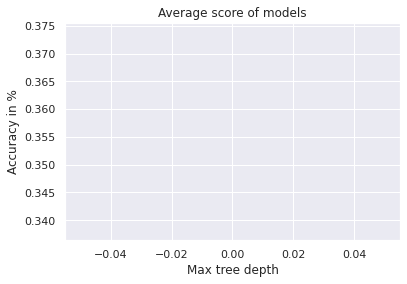

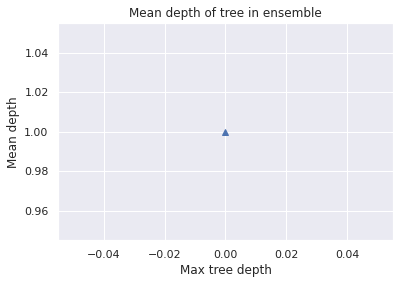

In [42]:
# narysujmy sobie zaleznosc wytrenowania i glebokosci
sns.set()
n = max(scores) + 1
# n = len(scores) + 1
to_plot_scores = [0] * n
to_plot_mean = [0] * n
to_plot_stddev = [0] * n

for i in scores.keys():
    print(i)
    to_plot_scores[i] = scores[i]
    to_plot_mean[i] = mean_depths[i]
    to_plot_stddev[i] = stddev_depths[i]
    
to_plot_scores.remove(0)
to_plot_mean.remove(0)
to_plot_stddev.remove(0)

plt.title("Average score of models")
plt.ylabel("Accuracy in %")
plt.xlabel("Max tree depth")
plt.plot(to_plot_scores)
plt.show()
    
# ax = sns.heatmap(quality)
# plt.show()
# print(to_plot_mean)
# print(to_plot_stddev)

plt.title("Mean depth of tree in ensemble")
plt.ylabel("Mean depth")
plt.xlabel("Max tree depth")
plt.errorbar(range(len(to_plot_mean)), to_plot_mean, to_plot_stddev, linestyle='None', marker='^')
plt.show()

In [43]:
# sprobujmy odtworzyc ten rezultat

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.3)

model = xgboost.XGBRegressor(n_estimators=5000, max_depth=2, subsample=0.5)
model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False, early_stopping_rounds=10)
res = model.predict(X_test)

c_statistic_harrell(model.predict(X_test), y_test)

ValueError: DataFrame.dtypes for data must be int, float, bool or category.  When
categorical type is supplied, DMatrix parameter `enable_categorical` must
be set to `True`. Invalid columns:payment_type, employment_status, housing_status, source, device_os

In [ ]:
for i in range(1,10):
    model = xgboost.XGBRegressor(n_estimators=1000, max_depth=i, subsample=0.5)
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False, early_stopping_rounds=10)
    res = model.predict(X_test)

    print("{}: {}".format(i, c_statistic_harrell(model.predict(X_test), y_test)))

In [ ]:
scores = {}
mean_depths = {}
stddev_depths = {}
full_depths = {}

mean = 10

for i in range(1,32):
    print(i)
    scores[i] = 0
    mean_depths[i] = 0
    stddev_depths[i] = 0
    for j in range(mean):
        model = xgboost.XGBRegressor(n_estimators=(100+i*100), max_depth=16, subsample=0.3)
        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
        model.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=10, verbose=False)
        scores[i] = scores[i] + model.score(X_test, y_test)
        
        booster = model.get_booster()
        tree_df = booster.trees_to_dataframe()
#         print("rysuje drzewo")
#         xgboost.plotting.plot_tree(booster)
        depths = [tree_depth(x) for x in booster.get_dump(dump_format = "json")]
        full_depths[i] = depths
        mean_depths[i] = mean_depths[i] + np.mean(depths)
        stddev_depths[i] = stddev_depths[i] + np.std(depths)
        
    scores[i] = scores[i] / mean
    mean_depths[i] = mean_depths[i] / mean
    stddev_depths[i] = stddev_depths[i] / mean

In [ ]:
print(scores)

In [ ]:
# narysujmy sobie zaleznosc wytrenowania i glebokosci w XGBoost
sns.set()
n = len(scores)
to_plot_scores = [0] * n
to_plot_mean = [0] * n
to_plot_stddev = [0] * n

for i in scores.keys():
    to_plot_scores[i-1] = scores[i]
    to_plot_mean[i-1] = mean_depths[i]
    to_plot_stddev[i-1] = stddev_depths[i]

plt.title("Average score of models")
plt.ylabel("Accuracy in %")
plt.xlabel("Max tree depth")
plt.plot(to_plot_scores)
plt.show()
    
# ax = sns.heatmap(quality)
# plt.show()
# print(to_plot_mean)
# print(to_plot_stddev)

plt.title("Mean depth of tree in ensemble")
plt.ylabel("Mean depth")
plt.xlabel("Max tree depth")
plt.errorbar(range(len(to_plot_mean)), to_plot_mean, to_plot_stddev, linestyle='None', marker='^')
plt.show()

In [ ]:
print(X.values)

In [ ]:
res_shap_cext = {}
res_banz_cext = {}

time_shap_cext = {}
time_banz_cext = {}

model_quality = {}

X,y = shap.datasets.boston()
X = X.values
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

for j in range (2,26,2):
    for i in range(100, 1000, 100):
        model = sklearn.ensemble.RandomForestRegressor(n_estimators=i, max_depth=j)
        model.fit(X_train, y_train)
        
        model_quality[(i, j)] = c_statistic_harrell(model.predict(X_test), y_test)
        
        print("------------------------------")
        print(j, i)
        print("---")
        
        start = time.time()
        res_shap_cext[(i, j)] = TreeCext(model).shap_values(X_test, banz=False)
        time_shap_cext[(i, j)] = time.time() - start
        print(time_shap_cext[(i, j)])

        start = time.time()
        res_banz_cext[(i, j)] = TreeCext(model).shap_values(X_test, banz=True)
        time_banz_cext[(i, j)] = time.time() - start
        print(time_banz_cext[(i, j)])

In [ ]:
time_shap_cext_prop = [ [time_shap_cext[(i, j)] for j in range (2,26,2)] for i in range(100, 1000, 100)]
time_banz_cext_prop = [ [time_banz_cext[(i, j)] for j in range (2,26,2)] for i in range(100
                                                                                        , 1000, 100)]

In [ ]:
time_diffs_banz_shap = \
    [ [ (time_shap_cext[(i, j)] - time_banz_cext[(i, j)]) / time_shap_cext[(i, j)] * 100 \
       for j in range (2,26,2)] for i in range(100, 1000, 100) ]

In [ ]:
plt.figure(figsize=(12, 9))
sns.heatmap(time_diffs_banz_shap, annot=True, fmt=".1f", linewidth=.5,\
           xticklabels=range(2,26,2), yticklabels=range(100, 1000, 100))
plt.title("Percentage of time improvement for TreeShap vs BANZ")
plt.ylabel("No. of trees")
plt.xlabel("Max tree depth")
plt.show()

In [ ]:
plot_qualities = [[model_quality[(i, j)] for j in range (2,26,2)] for i in range(100, 1000, 100)]

plt.figure(figsize=(12, 9))
sns.heatmap(plot_qualities, annot=True, fmt=".3f", linewidth=.5,\
           xticklabels=range(2,26,2), yticklabels=range(100, 1000, 100))
plt.title("C-index quality for model")
plt.ylabel("No. of trees")
plt.xlabel("Max tree depth")
plt.show()

In [ ]:
res_shap_cext_prop = [[res_shap_cext[(i, j)] for j in range (2,26,2)] for i in range(100, 1000, 100)]
res_banz_cext_prop = [[res_banz_cext[(i, j)] for j in range (2,26,2)] for i in range(100, 1000, 100)]
time_shap_cext_prop = [[time_shap_cext[(i, j)] for j in range (2,26,2)] for i in range(100, 1000, 100)]
time_banz_cext_prop = [[time_banz_cext[(i, j)] for j in range (2,26,2)] for i in range(100, 1000, 100)]

In [ ]:
X,y = shap.datasets.nhanesi()
X = X.values
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=7, test_size=0.2)

xgb_full = xgboost.DMatrix(X, label=y)
xgb_train = xgboost.DMatrix(X_train, label=y_train)
xgb_test = xgboost.DMatrix(X_test, label=y_test)

In [ ]:
params = {
    "eta": 0.2,
    "max_depth": 4, 
    "objective": "survival:cox",
    "subsample": 0.5,
}
model_full = xgboost.train(params, xgb_full, 5000, evals = [(xgb_full, "test")], verbose_eval=1000,\
                           early_stopping_rounds=250)

In [ ]:
c_statistic_harrell(model_full.predict(xgb_full), y)

In [ ]:
run_diff_explainers(model_full, xgb_train, xgb_full)

In [ ]:
model = xgboost.XGBRegressor(n_estimators=1000, max_depth=5, subsample=0.3)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
model.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=10, verbose=False)

booster = model.get_booster()
tree_df = booster.trees_to_dataframe()

In [ ]:
tree_df

In [ ]:
plt.plot([x * 10 for x in scores.values()])
plt.plot(mean_depths.values())
plt.plot(stddev_depths.values())

plt.show()

# wychodza glebokosci po 13 jak da mu sie wolna reke

In [ ]:
def show_results(attributions):
    a = attributions[1000]
    # print(a[0][1])


#     plt.stackplot(range(len(a[0][1].values[0])), a[0][1].values[0], a[1][1].values[0], a[2][1].values[0],
#                  labels=["Tree", "TreeBanz", "NEW TreeBanz"])
    
    plt.plot(range(len(a[0][1].values[0])), a[0][1].values[0])
    plt.plot(range(len(a[0][1].values[0])), a[1][1].values[0])
    plt.plot(range(len(a[0][1].values[0])), a[2][1].values[0])
    
    plt.legend()
    # plt.subplot(a)
    plt.show()

    shap.plots.bar(a[0][1][0]) #tree
    shap.plots.bar(a[1][1][0]) #treeBanz
    shap.plots.bar(a[2][1][0]) #NEWtreeBanz

In [ ]:
X,y = shap.datasets.boston()
X = X.values

model = xgboost.XGBRegressor(n_estimators=1000, max_depth=32, subsample=0.3)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
model.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=10, verbose=False)
X_eval = X_test[:1]

attributions = run_diff_explainers(model, X_train, X_eval)

# show_results(attributions)
c_statistic_harrell(model, X_test, y_test)

In [ ]:
X,y = shap.datasets.nhanesi()
X = X.values


for i in range(1,15):
    print("i={}".format(i))
    model = sklearn.ensemble.RandomForestRegressor(n_estimators=1000, max_depth=i)
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
    model.fit(X_train, y_train)
    X_eval = X_test[:1]

    attributions = run_diff_explainers(model, X_train, X_eval)

    y_predict = model.predict(X_test)
    # show_results(attributions)
    print("c-index:{}".format(c_statistic_harrell(y_predict, y_test)))
    print("mse:{}".format(np.sqrt(MSE(y_predict, y_test))))
    print("----------------------\n")

In [ ]:
x_ax = range(len(y_test))
plt.figure(figsize=(16, 8), dpi=100)
plt.plot(x_ax, y_test, label="original")
plt.plot(x_ax, y_predict, label="predicted")
plt.title("Boston dataset test and predicted data")
plt.xlabel('X')
plt.ylabel('Price')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show()

In [ ]:
v = {}
for i in range(3):
    v[i] = [(x / attributions[1000][i][1].values[0][0]) for x in attributions[1000][i][1].values[0]]

v

In [ ]:
shap.plots.beeswarm(a[0][1])
shap.plots.beeswarm(a[1][1])

In [ ]:
# # dry run to get all the code warmed up for valid runtime measurements
# for name, exp in explainers:
#     exp(X_eval[:1])

# explain with all the explainers
attributions = [run_explain(name, exp, X_eval) for name, exp in explainers]

In [ ]:
X, y = make_regression(n_samples=400, n_features=16, n_informative=8,random_state=0, shuffle=False)

model = sklearn.ensemble.RandomForestRegressor(n_estimators=1000, max_depth=10)
model.fit(X, y)

In [ ]:
# bst = xgboost.train({"learning_rate": 0.01, "max_depth": 4}, xgboost.DMatrix(X, label=y), 1000)

In [ ]:
# start = time.time()
# shap_values = bst.predict(xgboost.DMatrix(X), pred_contribs=True)
# print(time.time() - start)


In [ ]:

# x = X.head()
# x = X[:1]
x = X
x

In [ ]:
start = time.time()
res_shap_cext = TreeCext(model).shap_values(X, banz=False)
time_shap_cext = time.time() - start
time_shap_cext

In [ ]:
start = time.time()
res_banz_cext = TreeCext(model).shap_values(X, banz=True)
time_banz_cext = time.time() - start
time_banz_cext

In [ ]:
res_shap_cext

In [ ]:
res_banz_cext

In [ ]:
ex = TreeExplainer(model)
start = time.time()
res_shap_py = ex.shap_values(x)
time_shap_py = time.time() - start

In [ ]:
start = time.time()
res_banz_py = ex.banz_values(x)
time_banz_py = time.time() - start

In [ ]:
line = np.asarray(x[:1])
ex.brute_banz(line[0], 0)

In [ ]:
ex.brute_shap(line[0], 0)

In [ ]:
results_dict_cext = {}
results_dict_cext['banz'] = {}
results_dict_cext['shap'] = {}

In [ ]:
for i in range(1, 10):
    X, y = make_regression(n_samples=200 * i, n_features=16, n_informative=8,random_state=0, shuffle=False)

    model = sklearn.ensemble.RandomForestRegressor(n_estimators=1000 + 100 * i, max_depth=10 + i)
    model.fit(X, y)
    
    start = time.time()
    res_shap_cext = TreeCext(model).shap_values(x, banz=False)
    res_shap = time.time() - start
    
    start = time.time()
    res_banz_cext = TreeCext(model).shap_values(x, banz=True)
    res_banz = time.time() - start
    
    print(res_shap)
    print(res_banz)
    results_dict_cext['banz'][i] = res_banz
    results_dict_cext['shap'][i] = res_shap
    

In [ ]:
x = [i for i in results_dict_cext['banz']]
a1 = [results_dict_cext['banz'][i] for i in results_dict_cext['banz']]
a2 = [results_dict_cext['shap'][i] for i in results_dict_cext['shap']]

y_values = {"banz": a1, "treeshap": a2}
labels = ["BANZ", "TREESHAP"]

fig, ax = plt.subplots()
ax.stackplot(x, y_values.values(), labels=labels)

ax.legend(loc='upper left')
plt.show()

In [ ]:
results_dict_py = {}
results_dict_py['banz'] = {}
results_dict_py['shap'] = {}

In [ ]:
for i in range(1, 10):
    X, y = make_regression(n_samples=100 + 25 * i, n_features=6, n_informative=2,random_state=0, shuffle=False)

    model = sklearn.ensemble.RandomForestRegressor(n_estimators=100 + 25 * i, max_depth=4)
    model.fit(X, y)
    
    ex = TreeExplainer(model)
    print('created model')
    start = time.time()
    res_shap_py = ex.shap_values(X)
    time_shap_py = time.time() - start
    
    start = time.time()
    res_banz_py = ex.banz_values(X)
    time_banz_py = time.time() - start
    
    print(res_shap_py)
    print(res_banz_py)
    results_dict_py['banz'][i] = time_banz_py
    results_dict_py['shap'][i] = time_shap_py
    

In [ ]:
x = [i for i in results_dict_py['banz']]
a1 = [results_dict_py['banz'][i] for i in results_dict_py['banz']]
a2 = [results_dict_py['shap'][i] for i in results_dict_py['shap']]

y_values = {"banz": a1, "treeshap": a2}
labels = ["BANZ", "TREESHAP"]

fig, ax = plt.subplots()
ax.stackplot(x, y_values.values(), labels=labels)

ax.legend(loc='upper left')
plt.show()

In [ ]:
len(a1)

In [ ]:
len(a2)